In [6]:
# !pip install imageio matplotlib pandas

In [7]:
"""
Initialize setup and network with training code
""" 

import _init_lib_path
from datetime import datetime
import datetime as dt
import time

from utils.config import cfg
from epoch_loop import EpochLoop

import argparse
from utils.config_file_handling import cfg_from_file, cfg_from_list
from pprint import PrettyPrinter

pp = PrettyPrinter(indent=4)
cfg.TRAINING = True
import torch
torch.set_num_threads(32)
def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Training the network')

    parser.add_argument('-d', '--dataset-dir', dest='dataset_dir',
                        help='dataset directory', type=str, required=False)
    parser.add_argument('-e', '--experiment-dir', dest='experiment_dir',
                        help='a directory used to write experiment results', type=str, required=False)
    parser.add_argument('-u', '--use-gpu', dest='use_gpu',
                        help='whether to use gpu for the net inference', type=int, required=False)
    parser.add_argument('-g', '--gpu-id', dest='gpu_id',
                        help='gpu id to use', type=int, required=False)
    parser.add_argument('-c', '--cfg', dest='cfg_file',
                        help='optional config file to override the defaults', default=None, type=str)
    parser.add_argument('-s', '--set', dest='set_cfg',
                        help='set config arg parameters', default=None, nargs=argparse.REMAINDER)
    return parser.parse_args([])


def set_positional_cfg(args_in):
    args_list = []
    for n, a in args_in.__dict__.items():
        if a is not None and n not in ['cfg_file', 'set_cfg']:
            args_list += [n, a]
    return args_list

args = parse_args()

# print('Called with args:')
# print(args)

if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)
if args.set_cfg is not None:
    cfg_from_list(args.set_cfg)

cfg_from_list(set_positional_cfg(args))     # input arguments override cfg files and defaults

# print('configuration file cfg is loaded for training ...')
# pp.pprint(cfg)

epoch_loop = EpochLoop()
started_time = time.time()
epoch_loop.create_sets()
epoch_loop.setup_net()
epoch_loop.net.spatial_stream.load_state_dict(torch.load("../experiment/snapshot_UCF101_resnet/20200517_074837_564165/spt_099.pth"))
epoch_loop.net.temporal_stream.load_state_dict(torch.load("../experiment/snapshot_UCF101_resnet/20200517_074837_564165/tmp_099.pth"))

"""
setup validator
"""
import matplotlib
import matplotlib.pyplot as plt
import imageio
import numpy as np

from tqdm.notebook import trange, tqdm
epoch_loop.validator.set_net_mode(epoch_loop.net)

epoch_loop.validator.reset_meters()

"""
Load labels
"""
import os 
import pandas as pd
label_p = os.path.join('/home/srip19-pointcloud/linjun/dataset/ucf101/annotations', 'classInd.txt')
label_content = pd.read_csv(label_p, sep='delimiter', header=None, engine='python')
labels = {}
for i in range(len(label_content)):
    cls_id, cls_name = label_content.iloc[i, 0].split(' ')
    labels[int(cls_id)] = cls_name


creating training sets...
creating validation sets...
setup nets...
creating load
setting up optimizer...


13316

In [8]:
def val_sample(data_id):
    prediction_labels = []
    gt_labels = []
    image, flow, annotation = epoch_loop.validator.data_container.dataloader.dataset[data_id]
    image = torch.from_numpy(image).to(epoch_loop.validator.device)
    flow = torch.from_numpy(flow).to(epoch_loop.validator.device)

    with torch.no_grad():
        p = epoch_loop.net.forward(image.unsqueeze(0), flow.unsqueeze(0))
        if p[1] is None:
            p = p[0]
        else:
            p = torch.stack(p).mean(dim=0)
        #pred_label = p.argmax(dim=1)
        pred_label = np.argsort(-p.cpu().numpy())[0, :5]

    #     ## gt
        a = epoch_loop.validator.generate_gt([annotation])
        gt_labels = list(a.cpu().numpy())
    return [labels[l.item()] for l in (pred_label+1)], labels[gt_labels[0]+1]

In [9]:
# %matplotlib notebook
from IPython.display import HTML
from IPython.display import Image
def get_images(data_id):
    image, _, _ = epoch_loop.validator.data_container.dataloader.dataset[data_id]
    image = torch.from_numpy(image)#image.to(epoch_loop.validator.device)
    images = []
    for i in range(image.shape[1]-1):
        frame = image[:, i, :, :].permute(1,2,0).cpu().numpy()
        images.append((123+frame).astype(np.uint8))
    #     plt.imshow(frame)
    return images
def show_data_gif(data_id):
    
    imageio.mimsave('./demo.gif', get_images(data_id))

def valid_and_show(data_id):
    result = val_sample(data_id)
    print(result)
    show_data_gif(data_id)
    return result
    

(['ApplyEyeMakeup', 'ApplyLipstick', 'Typing', 'Haircut', 'PlayingFlute'], 'ApplyEyeMakeup')


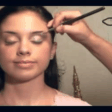

In [4]:
valid_and_show(42)
Image(filename="./demo.gif")

(['Archery', 'ParallelBars', 'Shotput', 'WritingOnBoard', 'WallPushups'], 'Archery')


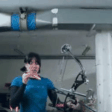

In [5]:
valid_and_show(100)
Image(filename="./demo.gif")

(['BaseballPitch', 'CricketBowling', 'Bowling', 'CricketShot', 'PommelHorse'], 'BaseballPitch')


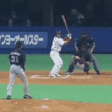

In [6]:
valid_and_show(256)
Image(filename="./demo.gif")

(['PlayingFlute', 'WallPushups', 'TaiChi', 'RockClimbingIndoor', 'BlowDryHair'], 'PlayingFlute')


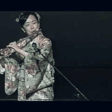

In [7]:
valid_and_show(2333)
Image(filename="./demo.gif")

(['BalanceBeam', 'ParallelBars', 'UnevenBars', 'FloorGymnastics', 'StillRings'], 'StillRings')


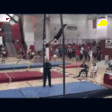

In [8]:
valid_and_show(3200)
Image(filename="./demo.gif")

![img](https://www.crcv.ucf.edu/data/UCF101/UCF101.jpg)

In [22]:
import os
from PIL import Image

def gen_demo_imgs(data_id):
    n_frames = 10
    UNIT_SIZE = 112 
    TARGET_WIDTH = n_frames * UNIT_SIZE


    images = get_images(data_id)

    for i in range(int(len(images)/n_frames)):
        imagefile = []
        j = 0
        for j in range(n_frames):
            imagefile.append(Image.fromarray(images[j]))
        target = Image.new('RGB', (TARGET_WIDTH, UNIT_SIZE))    
        left = 0
        right = UNIT_SIZE
        for image in imagefile:     
            target.paste(image, (left, 0, right, UNIT_SIZE))# 将image复制到target的指定位置中
            left += UNIT_SIZE # left是左上角的横坐标，依次递增
            right += UNIT_SIZE # right是右下的横坐标，依次递增
            quality_value = 100 # quality来指定生成图片的质量，范围是0～100
            target.save('./demo_{}.jpg'.format(data_id), quality = quality_value)
gen_demo_imgs(42)
gen_demo_imgs(256)

gen_demo_imgs(3200)